## King County Housing Data Analysis



![example](images/housingpicture.png)

Please fill out:
* Student name: Moses kuria
* Student pace:  part time 
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Overview

King County Real estate services wants to contract a construction company to build some houses in King County and the area of Seattle.Before it can do that, it wants to know what kind of houses to build to maximise profit by knowing the market value of the built house. As house prices are decided by a variety of factors, King County Real estate services wants to know exactly what those factors are to maximise profit. I am charged with exploring exactly what kind of houses have the best market prices and what it is that makes them so valuable. To do this, I will analyse data from the King County Housing datasets to draw actionable insights that they can use.

## Business Problem

The problem here is that King County Real Estate Services does not know exactly what kind of houses to build for it's customer base. It wants to know how different houses are priced and the likely factors that are driving that price evaluation. To do this, it must study the data and use different parameters to see what affects price the most. This allows them to predict the price in the future and build houses that will fetch revenue maximising profit.

## Data Understanding
This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015. The dataset includes basic house information such as the number of bedrooms & bathrooms, total area of the living space (divided into basement and above ground) & the lot, and year it was built, sales information like price & number of times it was viewed, and neighborhood information, like zipcode and information about the house and lot size of the 15 nearest neighbors.

I will use this data to build a model that will predict house prices based on the available variables.

In [1]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Your code here - remember to use markdown cells for comments as well
#importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import folium

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import LocalOutlierFactor
from yellowbrick.regressor import ResidualsPlot
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

pd.set_option('display.float_format', lambda x: f'{x:.2f}')
%matplotlib inline
plt.style.use('seaborn-darkgrid')


In [3]:
#defining functions that will aid in the analysis of the data

#defining a function that takes in categorical data
def ohe_concat(cat_data, cont_data, cat_list, column):
    
    # One hot encode categorical data
    cat_data_ohe = pd.get_dummies(cat_data, columns=cat_list, drop_first=False)
    # Concatenate cat_data_ohe with the continuous data
    preprocessed = pd.concat([cat_data_ohe, cont_data], axis=1)
    # Split into target feature and explanatory variables
    X = preprocessed.drop(column, axis=1)
    Y = preprocessed[column]
    return X, Y

def ols_summary(X_train, Y_train, X):
    
    # Build model
    model = sm.OLS(Y_train, sm.add_constant(pd.DataFrame(X_train, 
        columns=X.columns, index=X_train.index)))
    # Fit model
    results = model.fit()
    return results.summary()

def predictions(model, X_train, X_test, Y_train, Y_test):
    
    # Make predictions
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    # Calculate R2
    R2_train = r2_score(Y_train, Y_train_pred)
    R2_test = r2_score(Y_test, Y_test_pred)
    # Calculate mean absolute error
    mae_test = mean_absolute_error(Y_test, Y_test_pred)
    mae_train = mean_absolute_error(Y_train, Y_train_pred)
    # Calculate root mean squared error
    rmse_train = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
    # Print results of calculations
    print(f'Training Scores: R2 {R2_train:.5f}, Mean Absolute Error {mae_train:.2f}, Root Mean Squared Error {rmse_train:.2f}')
    print(f'Testing Scores: R2 {R2_test:.5f}, Mean Absolute Error {mae_test:.2f}, Root Mean Squared Error {rmse_test:.2f}')



In [4]:
#suppressing the warnings like function deprecation
warnings.filterwarnings(action = 'ignore')

In [5]:
#loading the dataset into a dataframe
#inspecting the beginning of the data

data = pd.read_csv('data/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.00,3,1.00,1180,5650,1.00,nan,0.00,...,7,1180,0.0,1955,0.00,98178,47.51,-122.26,1340,5650
1,6414100192,12/9/2014,538000.00,3,2.25,2570,7242,2.00,0.00,0.00,...,7,2170,400.0,1951,1991.00,98125,47.72,-122.32,1690,7639
2,5631500400,2/25/2015,180000.00,2,1.00,770,10000,1.00,0.00,0.00,...,6,770,0.0,1933,nan,98028,47.74,-122.23,2720,8062
3,2487200875,12/9/2014,604000.00,4,3.00,1960,5000,1.00,0.00,0.00,...,7,1050,910.0,1965,0.00,98136,47.52,-122.39,1360,5000
4,1954400510,2/18/2015,510000.00,3,2.00,1680,8080,1.00,0.00,0.00,...,8,1680,0.0,1987,0.00,98074,47.62,-122.05,1800,7503


In [6]:
#inspecting the tail of the data to get a general overview

data.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21592,263000018,5/21/2014,360000.00,3,2.50,1530,1131,3.00,0.00,0.00,...,8,1530,0.0,2009,0.00,98103,47.70,-122.35,1530,1509
21593,6600060120,2/23/2015,400000.00,4,2.50,2310,5813,2.00,0.00,0.00,...,8,2310,0.0,2014,0.00,98146,47.51,-122.36,1830,7200
21594,1523300141,6/23/2014,402101.00,2,0.75,1020,1350,2.00,0.00,0.00,...,7,1020,0.0,2009,0.00,98144,47.59,-122.30,1020,2007
21595,291310100,1/16/2015,400000.00,3,2.50,1600,2388,2.00,nan,0.00,...,8,1600,0.0,2004,0.00,98027,47.53,-122.07,1410,1287
21596,1523300157,10/15/2014,325000.00,2,0.75,1020,1076,2.00,0.00,0.00,...,7,1020,0.0,2008,0.00,98144,47.59,-122.30,1020,1357


In [7]:
#dropping the variables I don't intend to use in analysis
#describing the data getting key statistics

data.drop(["id", "date"], axis = 1, inplace = True)
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.00,21597.00,21597.00,21597.00,21597.00,21597.00,19221.00,21534.00,21597.00,21597.00,21597.00,21597.00,17755.00,21597.00,21597.00,21597.00,21597.00,21597.00
mean,540296.57,3.37,2.12,2080.32,15099.41,1.49,0.01,0.23,3.41,7.66,1788.60,1971.00,83.64,98077.95,47.56,-122.21,1986.62,12758.28
std,367368.14,0.93,0.77,918.11,41412.64,0.54,0.09,0.77,0.65,1.17,827.76,29.38,399.95,53.51,0.14,0.14,685.23,27274.44
min,78000.00,1.00,0.50,370.00,520.00,1.00,0.00,0.00,1.00,3.00,370.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,322000.00,3.00,1.75,1430.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,645000.00,4.00,2.50,2550.00,10685.00,2.00,0.00,0.00,4.00,8.00,2210.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


In [8]:
#getting a list of all the column names

data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [9]:
#inspecting the columns for missing values
#checking that the data has been stored in the correct data types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     19221 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17755 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  int64  
 18  sqft_l

It is to be noted that a number of columns have missing values. These are waterfront, view and yr_renovated columns. Sqft_basement data is stored in an object when it should be stored in either an int or a float. Changes are needed here as well as further investigation in the data. This will be done in the data preparation phase.

## Data preparation

In [10]:
#understanding the unique values of the column
#note a question mark is revealed as a unique value

data['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [11]:
data['bathrooms'].unique()

array([1.  , 2.25, 3.  , 2.  , 4.5 , 1.5 , 2.5 , 1.75, 2.75, 3.25, 4.  ,
       3.5 , 0.75, 4.75, 5.  , 4.25, 3.75, 1.25, 5.25, 6.  , 0.5 , 5.5 ,
       6.75, 5.75, 8.  , 7.5 , 7.75, 6.25, 6.5 ])

In [12]:
#Assigning the ? to a null value to convert the column to a float

data.loc[data['sqft_basement'] == '?', 'sqft_basement'] = np.nan
data.sqft_basement = data.sqft_basement.astype(float)

print(data['sqft_basement'].isna().sum())
print((data['sqft_living'] == data['sqft_basement'] + data['sqft_above']).sum())



454
21143


In [13]:
# replace the null values with the total sqft_living minus sqft_above

data['sqft_basement'] = data['sqft_basement'].fillna(data['sqft_living'] - data['sqft_above'])
(data['sqft_living'] == data['sqft_basement'] + data['sqft_above']).sum()

21597

In [14]:
#imputing the missing values in the waterfront column

data['waterfront'] = data.loc[data['waterfront']==0, 'waterfront']= 'No'
data['waterfront'] = data.loc[data['waterfront']==1, 'waterfront']= 'Yes'
data['waterfront'] = data['waterfront'].fillna('Unknown')

In [15]:
#getting a better sense of what the column contains

data['yr_renovated'].value_counts()

0.00       17011
2014.00       73
2003.00       31
2013.00       31
2007.00       30
           ...  
1946.00        1
1959.00        1
1971.00        1
1951.00        1
1954.00        1
Name: yr_renovated, Length: 70, dtype: int64

The 'yr_renovated' feature has a high number of zeros, which are likely homes that have not been renovated. It seems likely that the null values are also unrenovated homes. To combat this, convert all the zero values to not a number. Since we are interested in the possibility of renovation and not the exact time per say, we can convert this column to a categorical. To preserve the time aspect of it, we shall define a timeframe where we can classify the 'type' of renovation.

In [16]:
#converting all the zero values to Nan

data.loc[data['yr_renovated']== 0.0, 'yr_renovated'] = np.nan
data['yr_renovated'].notnull().sum()

744

In [17]:
#creating a categorical column defining type of categorical

data['renovated'] = np.where(data['yr_renovated']=='NaN', 'NR',
                             np.where(data['yr_renovated']<2005, 'R', 'RR'))

In [18]:
data.isna().sum()

price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                63
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated     20853
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
renovated            0
dtype: int64

We retain the null values because it is significant in our dataset. It shows that some houses have never been renovated.

In [19]:
numerical = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
               'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 
              'lat', 'long', 'zipcode', 'sqft_living15', 'sqft_lot15']

# New dataframe of numberical features only
data_num = data[numerical]

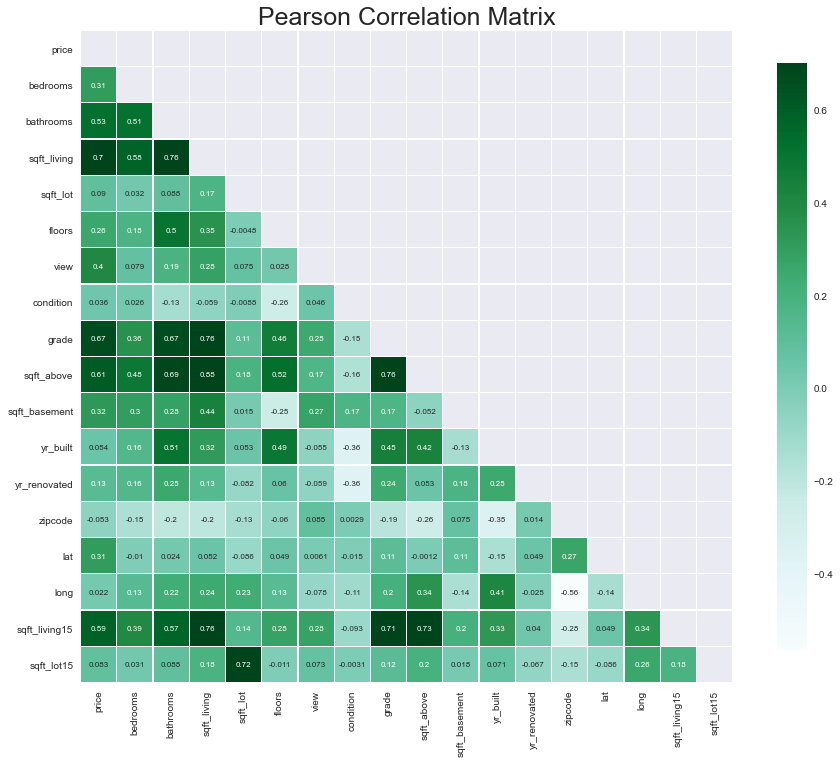

In [20]:

# Create a matrix of correlations between numerical features
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'zipcode','lat','long','sqft_living15','sqft_lot15']

mask = np.zeros_like(data[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

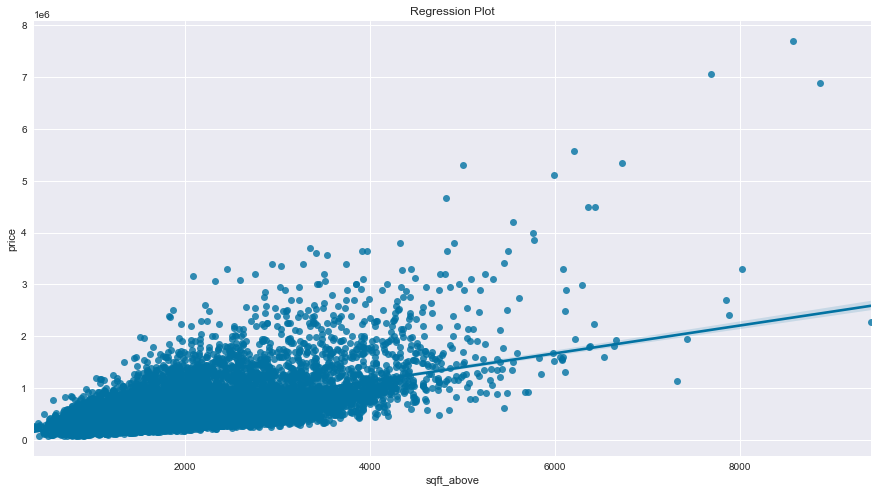

In [21]:
#pre-Checking the correlation of one variable to price
fig, ax = plt.subplots(figsize = (15,8))
sns.regplot(data['sqft_above'], data['price'])
plt.title("Regression Plot");

In [22]:
#creating a dataframe showing the correlation between features to avoid multicollinearity

df = data_num.corr().abs().stack().reset_index()
df.columns = ['feature1', 'feature2', 'corr']
df[(df['corr']>.75) & (df['corr'] <1)]

,feature1,feature2,corr
18,bathrooms,sqft_living,0.76
33,sqft_living,bathrooms,0.76
38,sqft_living,grade,0.76
39,sqft_living,sqft_above,0.88
46,sqft_living,sqft_living15,0.76
98,grade,sqft_living,0.76
103,grade,sqft_above,0.76
114,sqft_above,sqft_living,0.88
118,sqft_above,grade,0.76
226,sqft_living15,sqft_living,0.76


##  Modeling the data

We start by modelling the data using the most likely features to affect price of the house. From there, we can refine our model should there be anything we need to add.

In [23]:
# Divide data into continuous and categorical features. 
categoricals = ['waterfront', 'renovated', 'zipcode']
continuous = ['sqft_lot', 'sqft_lot15', 'sqft_living15', 'yr_built', 'condition',
              'bedrooms', 'bathrooms', 'sqft_above', 'sqft_basement', 'floors', 'price']
cat_data = data[categoricals]
cont_data = data[continuous]              


In [24]:
# One hot encode the categorical features, concatenate them with the continuous dataframe,
# then split the dataframe into the explanatory features, X, and target feature, y.

X, Y = ohe_concat(cat_data, cont_data, categoricals, 'price')

#splitting the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)


print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 4320
number of training samples: 17277


In [25]:
# Instantiate a dummy model that uses the mean of y_train as the predicted values
dummy_reg = DummyRegressor(strategy='mean')

# Fit the model with the training data
dummy_reg.fit(x_train, y_train)

# Get preditions on testing data and compare to the Y_test data set and print results
predictions(dummy_reg, x_train, x_test, y_train, y_test)


Training Scores: R2 0.00000, Mean Absolute Error 234693.12, Root Mean Squared Error 369492.79
Testing Scores: R2 -0.00022, Mean Absolute Error 232778.19, Root Mean Squared Error 358709.45


In [26]:
# Instantiate LinearRegression
linreg = LinearRegression()

# Fit the model with the training data
linreg.fit(x_train, y_train)

# Get preditions on testing data and compare to the Y_test data set and print results
predictions(linreg, x_train, x_test, y_train, y_test)

Training Scores: R2 0.74944, Mean Absolute Error 108480.68, Root Mean Squared Error 184952.37
Testing Scores: R2 0.76094, Mean Absolute Error 106532.88, Root Mean Squared Error 175366.39


The training and test R2 values are almost the same, indicating a good fit in the model.The root mean squared error is higher than the mean absolute error, indicating that there are some predicted values that are large.

In [27]:
# Running an Ordinary Least Squares model and get a results summary
ols_summary(x_train, y_train, X)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     642.9
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:19:22   Log-Likelihood:            -2.3405e+05
No. Observations:               17277   AIC:                         4.683e+05
Df Residuals:                   17196   BIC:                         4.689e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
waterfront_Yes  8.039e+05      1e+05      8.004      0.000    6.07e+05       1e+06
renovated_R     4.272e+05   4.94e+04      8.646      0.000     3.3e+05    5.24e+05
renovated_RR    3.767e+05   5.15e+04      7.314      0.000    2.76e+05    4.78e+05
zipcode_98001  -2.022e+05   1.11e+04    -18.248      0.000   -2.24e+05    -1.8e+05
zipcode_98002  -1.741e+05    1.5e+04    -11.577      0.000   -2.04e+05   -1.45e+05
zipcode_98003  -2.064e+05   1.25e+04    -16.524      0.000   -2.31e+05   -1.82e+05
zipcode_98004   5.712e+05   1.17e+04     48.893      0.000    5.48e+05    5.94e+05
zipcode_98005   1.046e+05   1.59e+04      6.596      0.000    7.35e+04    1.36e+05
zipcode_98006   8.544e+04   9989.593      8.553      0.000    6.59e+04    1.05e+05
zipcode_98007   5.348e+04   1.87e+04      2.866      0.004    1.69e+04       9e+04
zipcode_98008   9.911e+04   1.28e+04      7.764      0.000    7.41e+04    1.24e+05
zipcode_98010  -1.521e+05   2.08e+04     -7.315      0.000   -1.93e+05   -1.11e+05
zipcode_98011  -9.217e+04   1.47e+04     -6.260      0.000   -1.21e+05   -6.33e+04
zipcode_98014  -1.071e+05   1.83e+04     -5.846      0.000   -1.43e+05   -7.12e+04
zipcode_98019   -1.43e+05   1.51e+04     -9.475      0.000   -1.73e+05   -1.13e+05
zipcode_98022  -1.919e+05   1.37e+04    -14.048      0.000   -2.19e+05   -1.65e+05
zipcode_98023  -2.263e+05   9538.578    -23.723      0.000   -2.45e+05   -2.08e+05
zipcode_98024  -8.088e+04    2.4e+04     -3.365      0.001   -1.28e+05   -3.38e+04
zipcode_98027  -4.319e+04   1.05e+04     -4.123      0.000   -6.37e+04   -2.27e+04
zipcode_98028  -8.536e+04   1.22e+04     -6.990      0.000   -1.09e+05   -6.14e+04
zipcode_98029   1.783e+04   1.19e+04      1.495      0.135   -5552.363    4.12e+04
zipcode_98030  -2.039e+05   1.29e+04    -15.772      0.000   -2.29e+05   -1.79e+05
zipcode_98031  -2.002e+05   1.28e+04    -15.661      0.000   -2.25e+05   -1.75e+05
zipcode_98032  -1.842e+05   1.83e+04    -10.064      0.000    -2.2e+05   -1.48e+05
zipcode_98033   1.843e+05   1.02e+04     17.997      0.000    1.64e+05    2.04e+05
zipcode_98034   1.601e+04   9042.215      1.771      0.077   -1712.279    3.37e+04
zipcode_98038  -1.949e+05   9133.097    -21.337      0.000   -2.13e+05   -1.77e+05
zipcode_98039   1.086e+06   2.92e+04     37.126      0.000    1.03e+06    1.14e+06
zipcode_98040   3.664e+05   1.28e+04     28.723      0.000    3.41e+05    3.91e+05
zipcode_98042  -2.099e+05   9514.905    -22.064      0.000   -2.29e+05   -1.91e+05
zipcode_98045  -1.021e+05   1.44e+04     -7.080      0.000    -1.3e+05   -7.38e+04
zipcode_98052   2.274e+04   9125.592      2.492      0.013    4851.534    4.06e+04
zipcode_98053  -4.137e+04   1.11e+04     -3.735      0.000   -6.31e+04   -1.97e+04
zipcode_98055  -1.572e+05   1.25e+04    -12.597      0.000   -1.82e+05   -1.33e+05
zipcode_9805

The skew and kurtosis are both high, indicating the data is right skewed and there is a high number of outliers. The p-values for almost all features are significant. Let us plot the residuals and check for homoscedasticity.

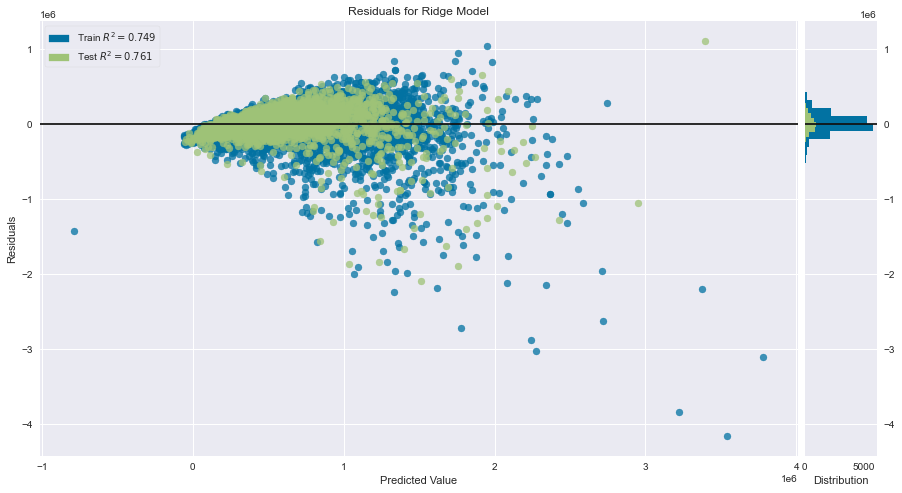

In [28]:
#defining the plot size
#instantiating the model and visualizer

fig, ax = plt.subplots(figsize = (15,8))
model = Ridge()
visualizer = ResidualsPlot(model)
# Fit the training data
visualizer.fit(x_train, y_train) 
# Score the test data
visualizer.score(x_test, y_test)
# Plot the residuals
visualizer.show();

The residuals plot shows that the results have high heteroscedasticity, showing that the model does a better job of predicting small values compared to larger values. To resolve the skew of the data as well as the heteroscedasticity, I will normalize the data and scale it to allow for less impact on the model from some values

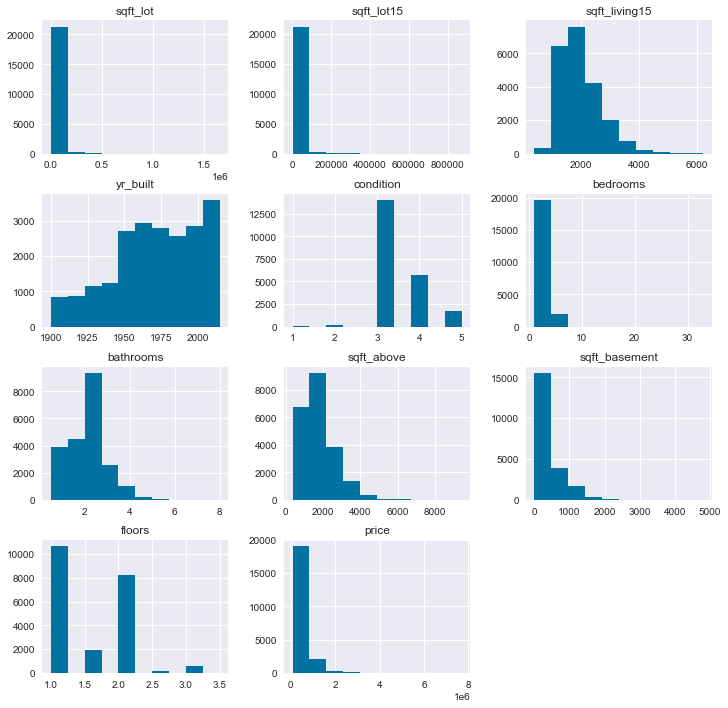

In [29]:
#visualizing the distribution of the data

cont_data.hist(figsize= (12, 12))
plt.show()

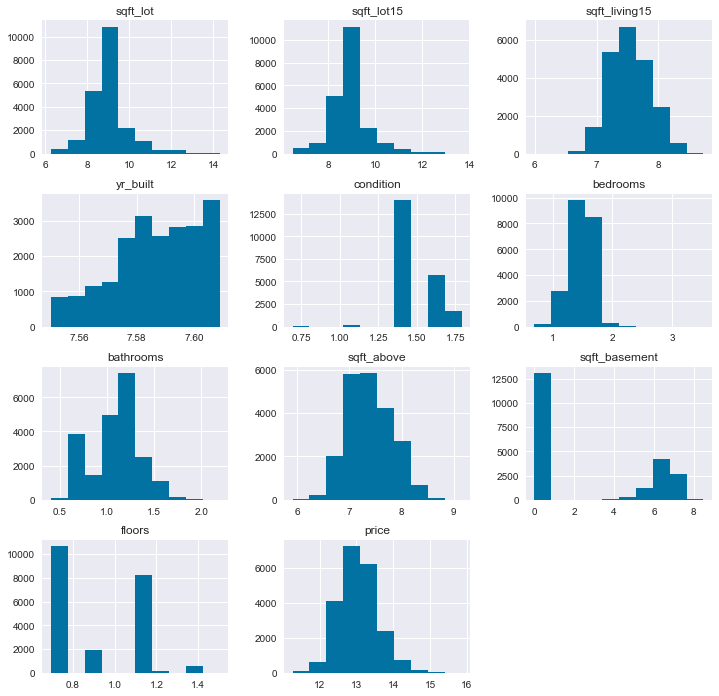

In [30]:
#applying a log transform to the data to normalize it

cont_data_log = np.log1p(cont_data)
cont_data_log.hist(figsize= (12, 12))
plt.show()

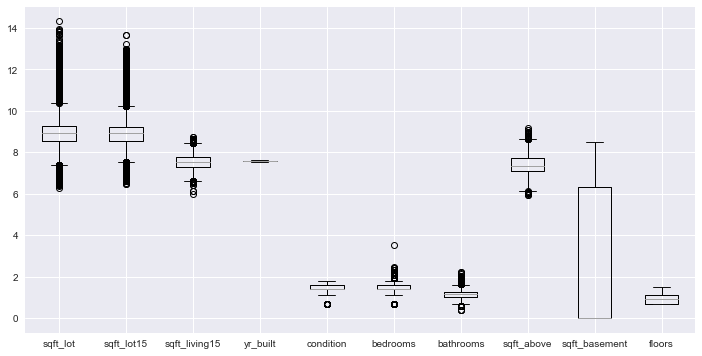

In [31]:
# Check continuous features for outliers. I excluded price as it is the target feature 
# and also on a scale much larger than the others
cont_data_log.drop(['price'], axis=1).boxplot(figsize= (12, 6));


Out of all the features, 6 of them have quite a number of outliers. Since the data is also well distributed, a RobustScaler would work well here to scale the features.

In [32]:
#one hot encoding the categorical data and concatenating the continuous data and the categorical data
X2, y2 = ohe_concat(cat_data, cont_data_log, categoricals, 'price')
# Split X2 and y2 into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state=9)

In [33]:
# Instantiate the RobustScaler
scaler = RobustScaler()
# Scale the training and testing data
X_train2_scaled = pd.DataFrame(scaler.fit_transform(X_train2))
X_test2_scaled = pd.DataFrame(scaler.transform(X_test2))

In [34]:
linreg2 = LinearRegression()
# Fit the scaled training data
linreg2.fit(X_train2_scaled, y_train2)
# Get predictions on testing data and pring results
predictions(linreg2, X_train2_scaled, X_test2_scaled, y_train2, y_test2)


Training Scores: R2 0.85060, Mean Absolute Error 0.15, Root Mean Squared Error 0.20
Testing Scores: R2 0.84506, Mean Absolute Error 0.15, Root Mean Squared Error 0.21


Again, the training and the test R2 scores are similar indicating that there is still a good fit in the model. Additionally, the R2 values have increased from 0.75 to 0.85. This is due to the scaling and normalization of the data. The root mean squared error is still higher than the mean absolute error. However, the difference between the two has been reduced indicating there are fewer predictions with large errors.

In [35]:
# Run an Ordinary Least Squares model and get a results summary
ols_summary(X_train2, y_train2, X2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     1224.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:19:27   Log-Likelihood:                 3020.1
No. Observations:               17277   AIC:                            -5878.
Df Residuals:                   17196   BIC:                            -5250.
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
waterfront_Yes     1.0433      0.865      1.207      0.228      -0.651       2.738
renovated_R        0.5542      0.431      1.286      0.198      -0.291       1.399
renovated_RR       0.4891      0.434      1.128      0.259      -0.361       1.339
zipcode_98001     -0.5094      0.018    -28.033      0.000      -0.545      -0.474
zipcode_98002     -0.5102      0.021    -24.722      0.000      -0.551      -0.470
zipcode_98003     -0.4672      0.019    -25.092      0.000      -0.504      -0.431
zipcode_98004      0.6655      0.018     36.521      0.000       0.630       0.701
zipcode_98005      0.2297      0.022     10.415      0.000       0.186       0.273
zipcode_98006      0.2127      0.017     12.596      0.000       0.180       0.246
zipcode_98007      0.1677      0.023      7.288      0.000       0.123       0.213
zipcode_98008      0.2060      0.019     11.109      0.000       0.170       0.242
zipcode_98010     -0.3120      0.027    -11.726      0.000      -0.364      -0.260
zipcode_98011     -0.0690      0.020     -3.369      0.001      -0.109      -0.029
zipcode_98014     -0.2403      0.025     -9.668      0.000      -0.289      -0.192
zipcode_98019     -0.2234      0.022    -10.291      0.000      -0.266      -0.181
zipcode_98022     -0.4545      0.021    -22.153      0.000      -0.495      -0.414
zipcode_98023     -0.5148      0.017    -30.733      0.000      -0.548      -0.482
zipcode_98024     -0.0997      0.028     -3.551      0.000      -0.155      -0.045
zipcode_98027      0.0120      0.017      0.687      0.492      -0.022       0.046
zipcode_98028     -0.0810      0.019     -4.327      0.000      -0.118      -0.044
zipcode_98029      0.1336      0.019      7.218      0.000       0.097       0.170
zipcode_98030     -0.4742      0.020    -24.073      0.000      -0.513      -0.436
zipcode_98031     -0.4422      0.019    -22.908      0.000      -0.480      -0.404
zipcode_98032     -0.4930      0.024    -20.957      0.000      -0.539      -0.447
zipcode_98033      0.3241      0.017     19.123      0.000       0.291       0.357
zipcode_98034      0.0687      0.016      4.237      0.000       0.037       0.100
zipcode_98038     -0.3650      0.017    -21.779      0.000      -0.398      -0.332
zipcode_98039      0.8810      0.034     26.182      0.000       0.815       0.947
zipcode_98040      0.4565      0.019     24.136      0.000       0.419       0.494
zipcode_98042     -0.4517      0.017    -26.781      0.000      -0.485      -0.419
zipcode_98045     -0.1782      0.021     -8.586      0.000      -0.219      -0.137
zipcode_98052      0.1458      0.016      8.908      0.000       0.114       0.178
zipcode_98053      0.0665      0.018      3.634      0.000       0.031       0.102
zipcode_98055     -0.3619      0.019    -19.383      0.000      -0.399      -0.325
zipcode_9805

The skew and kurtosis are both in the normal range, indicating the data no longer skewed and outliers have been minimized. Our log transform and scale has worked in reducing the skew and getting our data to be homoskedastic.

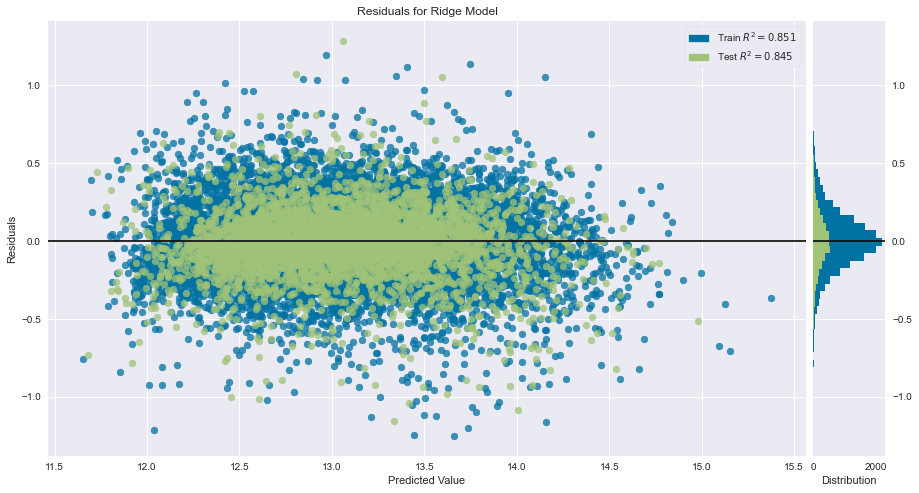

In [36]:
#defining the plot size
#instantiating the model and visualizer

fig, ax = plt.subplots(figsize = (15,8))
model = Ridge()
visualizer = ResidualsPlot(model)
# Fit the training data
visualizer.fit(X_train2_scaled, y_train2) 
# Evaluate the model using the test data
visualizer.score(X_test2_scaled, y_test2)  
# Plot the residuals
visualizer.show();

Our residuals plot confirms that our data is now much more homoskedastic.

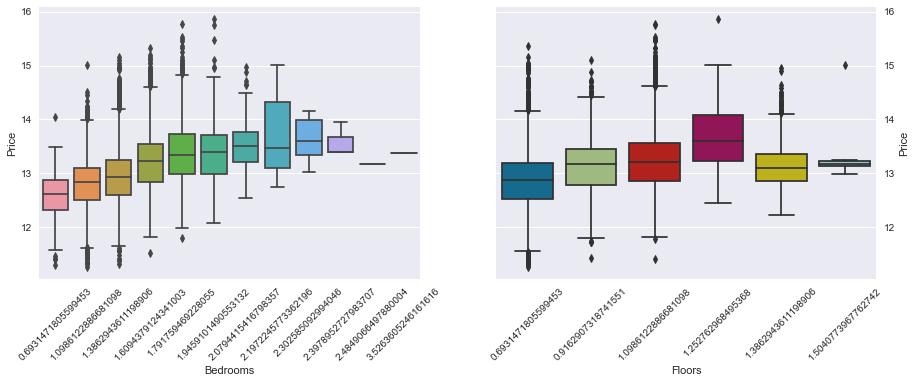

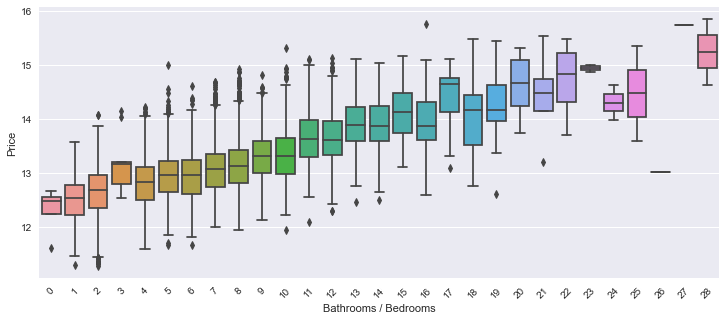

In [37]:
fig, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=cont_data_log['bedrooms'],y=cont_data_log['price'], ax=axes[0])
sns.boxplot(x=cont_data_log['floors'],y=cont_data_log['price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Bedrooms', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Price')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)

for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)



f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=cont_data_log['bathrooms'],y=cont_data_log['price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms / Bedrooms', ylabel='Price')
axe.set_xticklabels(axe.get_xticks(), rotation = 45);

To determine bedrooms, floors or bathrooms/bedrooms vs price, I preferred boxplot. Looking at the data, all these features seem to have outliers. Let us try to model the data without outliers and see what effect it would have on the data. 

In [38]:
categoricals2 = ['waterfront', 'renovated', 'zipcode']
continuous2 = ['sqft_lot', 'sqft_living15', 'sqft_above', 'sqft_basement', 'price', 'bathrooms',
              'condition', 'bedrooms', 'floors']
cat_data2 = data[categoricals2]
cont_data2 = data[continuous2]

# Log transform continuous data
cont_data_log2 = np.log1p(cont_data2)

# One hot encode categorical data, concatenate it with continuos data and split into
# explanatory features and target feature
X3, y3 = ohe_concat(cat_data2, cont_data_log2, categoricals2, 'price')

# Split data into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2, random_state=14)


Use LocalOutlierFactor to find outliers using nearest neighbors, then create training datasets without the outliers.

In [39]:
#Instantiate LocalOutlierFactor 
#Fit and predict the training data

lof = LocalOutlierFactor()
y_pred = lof.fit_predict(X_train2)

# Outliers are assigned '-1'. Create mask of inlier data
mask = y_pred != -1

# Use mask to eliminate outliers from training data
X_train3, y_train3 = X_train3.iloc[mask, :], y_train3.iloc[mask]



In [40]:
#checking to see how many outliers were eliminated

print(X_train3.shape)
X_train2.shape

(16281, 81)


(17277, 83)

In [41]:
#scale the data using MinMaxScaler

scaler2= MinMaxScaler()
X_train3_scaled = pd.DataFrame(scaler2.fit_transform(X_train3))
X_test3_scaled = pd.DataFrame(scaler2.transform(X_test3))


In [42]:
#Instantiate LinearRegression

linreg3 = LinearRegression()
# Fit model
linreg3.fit(X_train3, y_train3)

# Make predictions
predictions(linreg3, X_train3, X_test3, y_train3, y_test3)


Training Scores: R2 0.85027, Mean Absolute Error 0.15, Root Mean Squared Error 0.20
Testing Scores: R2 0.84570, Mean Absolute Error 0.15, Root Mean Squared Error 0.21


In [43]:
# Run an Ordinary Least Squares model and get a results summary
ols_summary(X_train3, y_train3, X3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     1180.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        11:19:32   Log-Likelihood:                 2868.4
No. Observations:               16281   AIC:                            -5579.
Df Residuals:                   16202   BIC:                            -4971.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
waterfront_Yes     3.8298      0.036    105.472      0.000       3.759       3.901
renovated_R        1.9431      0.020     99.468      0.000       1.905       1.981
renovated_RR       1.8866      0.018    102.440      0.000       1.851       1.923
zipcode_98001     -0.4727      0.012    -37.845      0.000      -0.497      -0.448
zipcode_98002     -0.4743      0.017    -27.445      0.000      -0.508      -0.440
zipcode_98003     -0.4291      0.014    -31.253      0.000      -0.456      -0.402
zipcode_98004      0.7189      0.013     53.684      0.000       0.693       0.745
zipcode_98005      0.2795      0.019     14.810      0.000       0.242       0.316
zipcode_98006      0.2545      0.011     23.247      0.000       0.233       0.276
zipcode_98007      0.2126      0.020     10.635      0.000       0.173       0.252
zipcode_98008      0.2647      0.014     19.027      0.000       0.237       0.292
zipcode_98010     -0.2590      0.023    -11.402      0.000      -0.304      -0.214
zipcode_98011     -0.0381      0.017     -2.306      0.021      -0.071      -0.006
zipcode_98014     -0.1894      0.022     -8.649      0.000      -0.232      -0.146
zipcode_98019     -0.1786      0.017    -10.695      0.000      -0.211      -0.146
zipcode_98022     -0.4034      0.015    -26.349      0.000      -0.433      -0.373
zipcode_98023     -0.4687      0.011    -44.327      0.000      -0.489      -0.448
zipcode_98024     -0.0733      0.027     -2.742      0.006      -0.126      -0.021
zipcode_98027      0.0466      0.012      3.983      0.000       0.024       0.070
zipcode_98028     -0.0410      0.014     -2.956      0.003      -0.068      -0.014
zipcode_98029      0.1822      0.013     13.613      0.000       0.156       0.208
zipcode_98030     -0.4135      0.015    -28.149      0.000      -0.442      -0.385
zipcode_98031     -0.4098      0.014    -28.601      0.000      -0.438      -0.382
zipcode_98032     -0.4764      0.022    -21.657      0.000      -0.519      -0.433
zipcode_98033      0.3560      0.011     31.520      0.000       0.334       0.378
zipcode_98034      0.1043      0.010     10.175      0.000       0.084       0.124
zipcode_98038     -0.3206      0.010    -32.697      0.000      -0.340      -0.301
zipcode_98039      0.8853      0.033     26.979      0.000       0.821       0.950
zipcode_98040      0.4974      0.014     34.953      0.000       0.470       0.525
zipcode_98042     -0.4101      0.010    -40.468      0.000      -0.430      -0.390
zipcode_98045     -0.1413      0.016     -8.973      0.000      -0.172      -0.110
zipcode_98052      0.1883      0.010     18.827      0.000       0.169       0.208
zipcode_98053      0.1067      0.012      8.897      0.000       0.083       0.130
zipcode_98055     -0.3015      0.014    -21.068      0.000      -0.330      -0.273
zipcode_9805

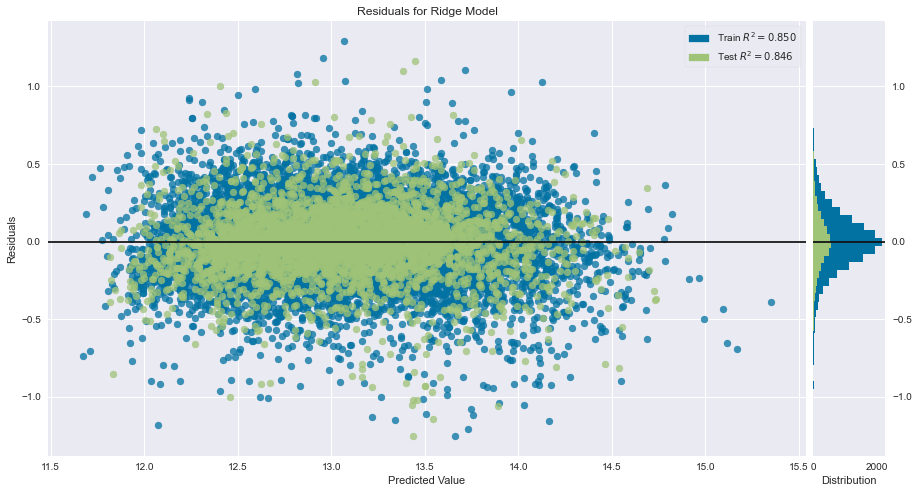

<Figure size 432x288 with 0 Axes>

In [44]:
# Instantiate the linear model and visualizer
fig, ax = plt.subplots(figsize = (15,8))
model = Ridge()
visualizer3 = ResidualsPlot(model)

# Fit the training data
visualizer3.fit(X_train3, y_train3)  
# Evaluate the model using the test data
visualizer3.score(X_test3, y_test3)
# Plot the residuals
visualizer3.show();
plt.savefig("images/modelconfidence.png", bbox_inches='tight')

Plotting the residuals shows that the data is homoskedastic. The R-squared values are fairly the same as in the previous model hence leading to the conclusion that the outliers had little to no effect on the accuracy of the model.

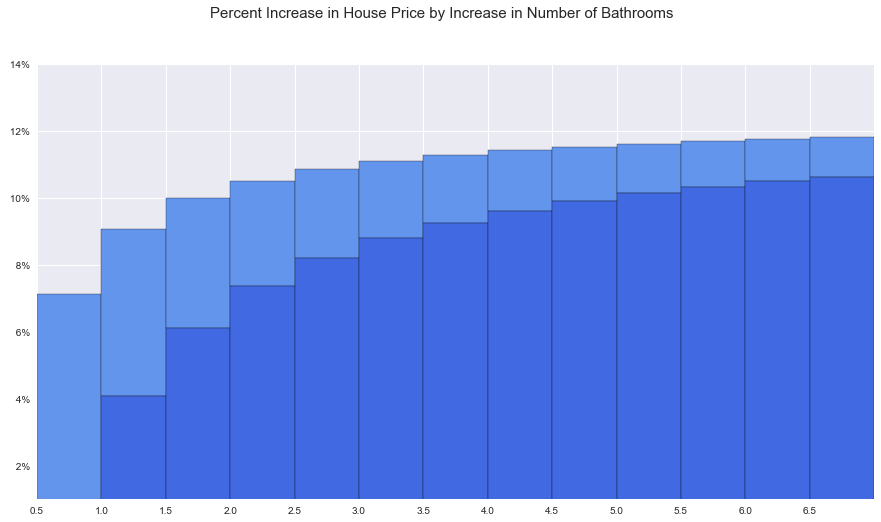

In [45]:
# Plot how an increase in number of bathrooms affects house price.

# List of possible number of bathrooms
bath_num = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]

# List to contain incremental percent increase in price
# This is a step wise increase for each 0.5 bath added
incremental_increase = []
for num in bath_num:
    # Calculate percent increase in adding a half bath.
    pct_increase = (0.5 / num) + 1
    # Use the bathroom coef to calculate the corresponding increase in price
    transform = (pct_increase**0.17 - 1)*100
    incremental_increase.append(transform)
    
# List to contain incremental percent increase in price
# This is the total increase of x number of baths than a 0.5 bath   
total_increase = []
for num in bath_num:
    # Calculate total percent increase from a half bath to bath_num
    pct_increase = ((num - 0.5) / num) + 1
    # Use the bathroom coef to calculate the corresponding increase in price
    transform = (pct_increase**0.17 - 1)*100
    total_increase.append(transform)
    
# Find the difference in total and incremental increases for the 
# stacked bar graph
tot_inc = np.array(total_increase)
inc_inc = np.array(incremental_increase)
diff = tot_inc - inc_inc


# Plot percent increase in price with bathroom number
fig, ax = plt.subplots(figsize = (15,8))
plt.suptitle('Percent Increase in House Price by Increase in Number of Bathrooms', fontsize=15)
plt.xlabel('Number of Bathrooms', fontsize=12)
plt.ylabel('Percent Increase in House Price', fontsize=12)
ax = plt.axes()
ax.set(ylim=(1, 14),xlim=(1, 7)) 
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x: .0f}%'))
ax.set_xticks([x-0.5 for x in bath_num])
plt.subplots_adjust(top=0.88) 

plt.bar(bath_num, incremental_increase, align='edge', width= -0.5, edgecolor='black', 
        color='cornflowerblue', bottom=diff)
plt.bar(bath_num, diff, align='edge', width= -0.5, color='royalblue', edgecolor='black')

# Save and plot
plt.savefig("images/increasebybathroom.png", bbox_inches='tight')
plt.show()


From the graph, it is easy to see that the effect of bathrooms on house prices decreases with increase in bathrooms. One can infer that bathrooms, while important, don't really have an effect on the house prices.

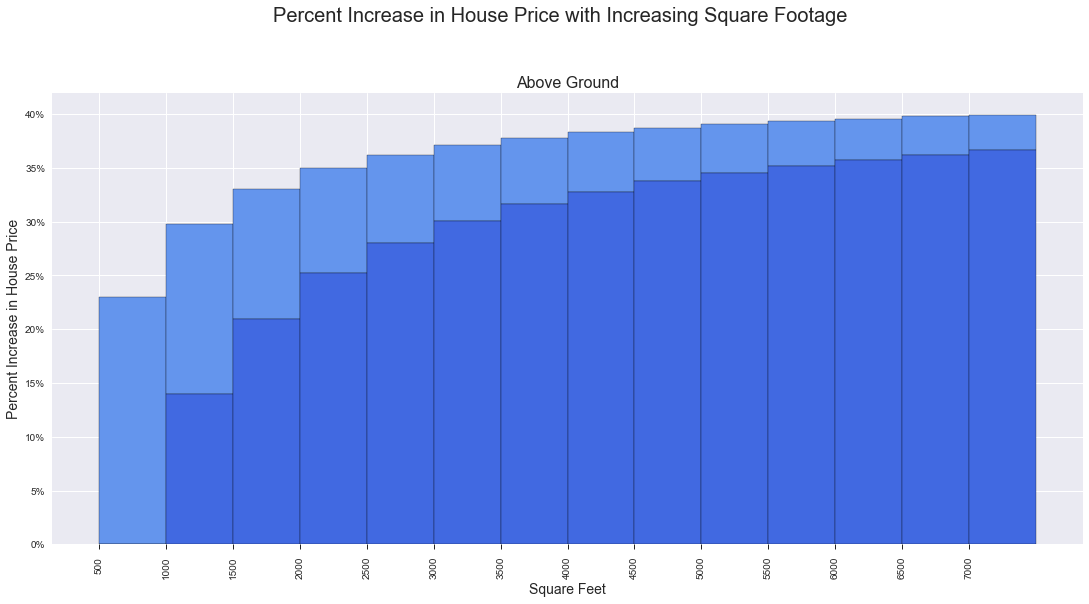

In [46]:
# Plot how an increase in square feet affects house price.
fig, ax = plt.subplots( figsize=(15, 8))

# List to contain incremental percent increase in price
# for increase sqft above ground
incremental_increase_abv = []
for num in range(1000, 8000, 500):
    # Calculate percent increase in adding 500 sqft
    pct_increase = (500 / num) + 1
    # Use the bathroom coef to calculate the corresponding increase in price
    transform = (pct_increase**0.51 - 1)*100
    incremental_increase_abv.append(transform)
    
# List to contain total percent increase in price
total_increase_abv = []
for num in range(1000, 8000, 500):
    # Calculate total percent increase from 500 sqft
    pct_increase = ((num - 500) / num) + 1
    # Use the bathroom coef to calculate the corresponding increase in price
    transform = (pct_increase**0.51 - 1)*100
    total_increase_abv.append(transform)
    
# Find the difference in total and incremental increases for the 
# stacked bar graph
tot_inc_abv = np.array(total_increase_abv)
inc_inc_abv = np.array(incremental_increase_abv)
diff_abv = tot_inc_abv - inc_inc_abv



fig.suptitle('Percent Increase in House Price with Increasing Square Footage', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.83)

ax.set_title('Above Ground', fontsize=16)
ax.set_xlabel('Square Feet', fontsize=14)
ax.set_ylabel('Percent Increase in House Price', fontsize=14)
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}%'))
ax.xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
ax.set_xticks([x-500 for x in range(1000, 8000, 500)])
ax.set_xticklabels([x-500 for x in range(1000, 8000, 500)],rotation=90)
ax.tick_params(axis='x', which='both', length=5)

ax.bar(range(1000, 8000, 500), incremental_increase_abv, align='edge', width= -500, edgecolor='black', 
        color='cornflowerblue', bottom=diff_abv)
ax.bar(range(1000, 8000, 500), diff_abv, align='edge', width= -500, color='royalblue', edgecolor='black')

plt.savefig("images/increasebysqftabove.png", bbox_inches='tight')
plt.show()

In [47]:
#calculating the intercept and coefficient for our regression line

from sklearn import metrics
from sklearn.model_selection import cross_val_score
train_data,test_data = train_test_split(cont_data_log,train_size = 0.8,random_state=3)

lr = LinearRegression()
X_train = np.array(train_data['sqft_above'], dtype=pd.Series).reshape(-1,1)
y_train = np.array(train_data['price'], dtype=pd.Series)
lr.fit(X_train,y_train)

X_test = np.array(test_data['sqft_above'], dtype=pd.Series).reshape(-1,1)
y_test = np.array(test_data['price'], dtype=pd.Series)

pred = lr.predict(X_test)
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrsm = float(format(lr.score(X_train, y_train),'.3f'))
rtesm = float(format(lr.score(X_test, y_test),'.3f'))
cv = float(format(cross_val_score(lr,cont_data_log[['sqft_above']],cont_data_log['price'],cv=5).mean(),'.3f'))

print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficient: {}'.format(lr.coef_))


Average Price for Test Data: 13.041
Intercept: 7.6711443317588195
Coefficient: [0.72729166]


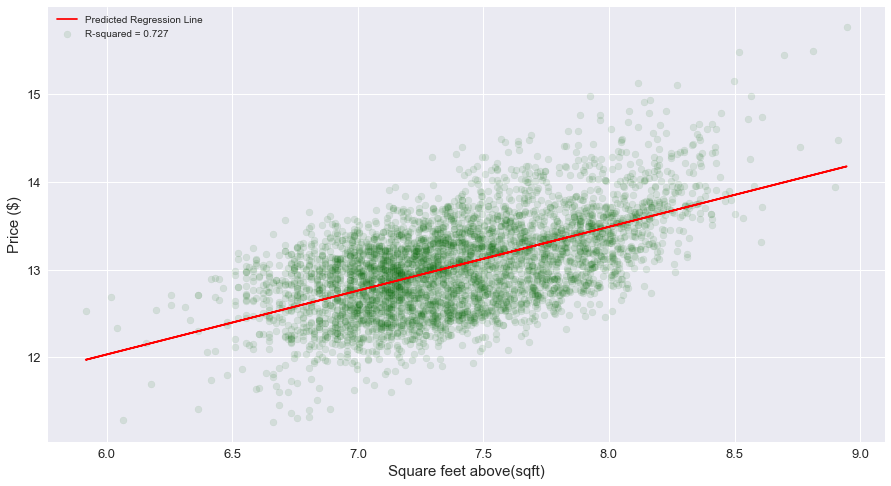

In [48]:
#plotting a regression line to visualize how well the square feet above correlates
#with price
plt.figure(figsize=(15,8))
plt.scatter(X_test,y_test,color='darkgreen',label="R-squared = 0.727", alpha=.1)
plt.plot(X_test,lr.predict(X_test),color="red",label="Predicted Regression Line")
plt.xlabel("Square feet above(sqft)", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig("images/sqftregression.png", bbox_inches='tight')

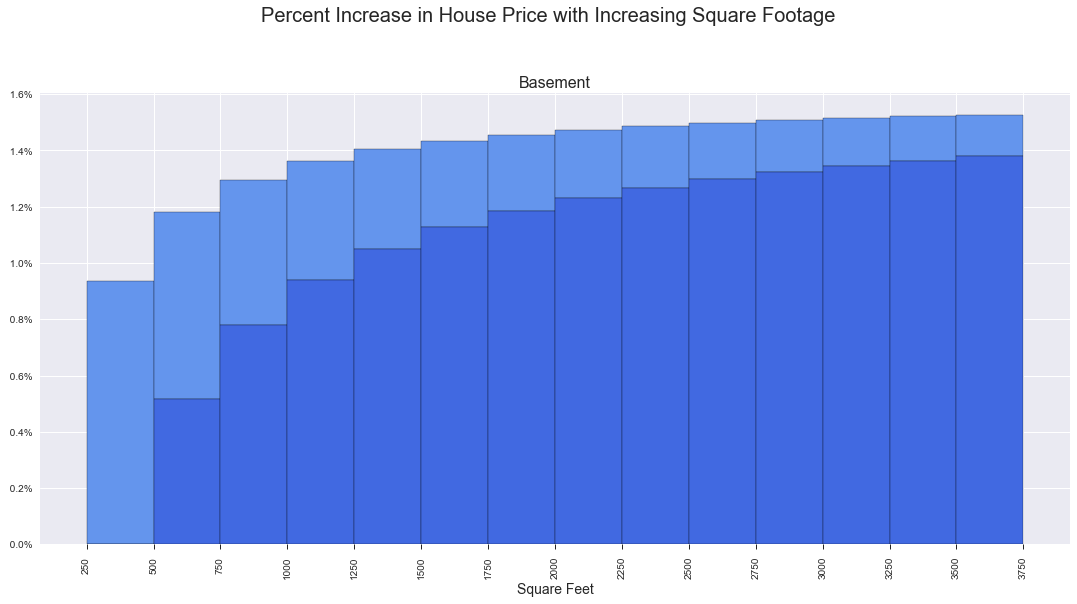

In [49]:
fig, ax =  plt.subplots(figsize = (15,8))

# List to contain incremental percent increase in price
# for increase sqft basement
incremental_increase_bsmt = []    
for num in range(500, 4000, 250):
    # Calculate percent increase in adding 500 sqft
    pct_increase = (250 / num) + 1
    # Use the bathroom coef to calculate the corresponding increase in price
    transform = (pct_increase**0.023 - 1)*100
    incremental_increase_bsmt.append(transform)

total_increase_bsmt = []    
for num in range(500, 4000, 250):
    # Calculate total percent increase from 500 sqft
    pct_increase = ((num - 250) / num) + 1
    # Use the bathroom coef to calculate the corresponding increase in price
    transform = (pct_increase**0.023 - 1)*100
    total_increase_bsmt.append(transform)
    
# Find the difference in total and incremental increases for the 
# stacked bar graph
tot_inc_bsmt = np.array(total_increase_bsmt)
inc_inc_bsmt = np.array(incremental_increase_bsmt)
diff_bsmt = tot_inc_bsmt - inc_inc_bsmt
    
fig.suptitle('Percent Increase in House Price with Increasing Square Footage', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.83)

ax.set_title('Basement', fontsize=16)
ax.set_xlabel('Square Feet', fontsize=14)
ax.set_ylabel
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x: .1f}%'))
ax.xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:.0f}'))
#ax2.bar(range(500, 4000, 500), increase_bsmt, align='edge', width=500, edgecolor='black')
ax.set_xticks([x-250 for x in range(500, 4500, 250)])
ax.set_xticklabels([x-250 for x in range(500, 4500, 250)],rotation=90)
ax.tick_params(axis='x', which='both', length=5)

ax.bar(range(500, 4000, 250), incremental_increase_bsmt, align='edge', width= -250, edgecolor='black', 
        color='cornflowerblue', bottom=diff_bsmt)
ax.bar(range(500, 4000, 250), diff_bsmt, align='edge', width= -250, color='royalblue', edgecolor='black')

plt.savefig("images/increasebysqft.png", bbox_inches='tight')
plt.show()


In [50]:
#calculating the intercept and coefficient for our regression line

from sklearn import metrics
from sklearn.model_selection import cross_val_score
train_data,test_data = train_test_split(cont_data_log,train_size = 0.8,random_state=3)

lr = LinearRegression()
X_train = np.array(train_data['sqft_basement'], dtype=pd.Series).reshape(-1,1)
y_train = np.array(train_data['price'], dtype=pd.Series)
lr.fit(X_train,y_train)

X_test = np.array(test_data['sqft_basement'], dtype=pd.Series).reshape(-1,1)
y_test = np.array(test_data['price'], dtype=pd.Series)

pred = lr.predict(X_test)
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrsm = float(format(lr.score(X_train, y_train),'.3f'))
rtesm = float(format(lr.score(X_test, y_test),'.3f'))
cv = float(format(cross_val_score(lr,cont_data_log[['sqft_basement']],cont_data_log['price'],cv=5).mean(),'.3f'))

print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficient: {}'.format(lr.coef_))


Average Price for Test Data: 13.041
Intercept: 12.950205621238144
Coefficient: [0.03963004]


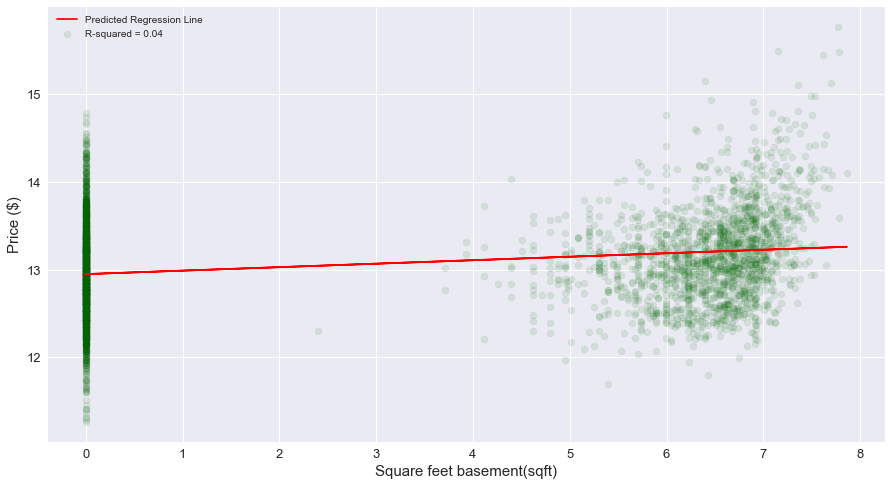

In [51]:
#plotting a regression line to visualize how well the square feet basement correlates
#with price
plt.figure(figsize=(15,8))
plt.scatter(X_test,y_test,color='darkgreen',label="R-squared = 0.04", alpha=.1)
plt.plot(X_test,lr.predict(X_test),color="red",label="Predicted Regression Line")
plt.xlabel("Square feet basement(sqft)", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig("images/sqftbase.png", bbox_inches='tight')

In [52]:
#calculating the intercept and coefficient for our regression line

from sklearn import metrics
from sklearn.model_selection import cross_val_score
train_data,test_data = train_test_split(cont_data_log,train_size = 0.8,random_state=3)

lr = LinearRegression()
X_train = np.array(train_data['sqft_living15'], dtype=pd.Series).reshape(-1,1)
y_train = np.array(train_data['price'], dtype=pd.Series)
lr.fit(X_train,y_train)

X_test = np.array(test_data['sqft_living15'], dtype=pd.Series).reshape(-1,1)
y_test = np.array(test_data['price'], dtype=pd.Series)

pred = lr.predict(X_test)
rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrsm = float(format(lr.score(X_train, y_train),'.3f'))
rtesm = float(format(lr.score(X_test, y_test),'.3f'))
cv = float(format(cross_val_score(lr,cont_data_log[['sqft_living15']],cont_data_log['price'],cv=5).mean(),'.3f'))

print ("Average Price for Test Data: {:.3f}".format(y_test.mean()))
print('Intercept: {}'.format(lr.intercept_))
print('Coefficient: {}'.format(lr.coef_))


Average Price for Test Data: 13.041
Intercept: 5.679791287397324
Coefficient: [0.97744137]


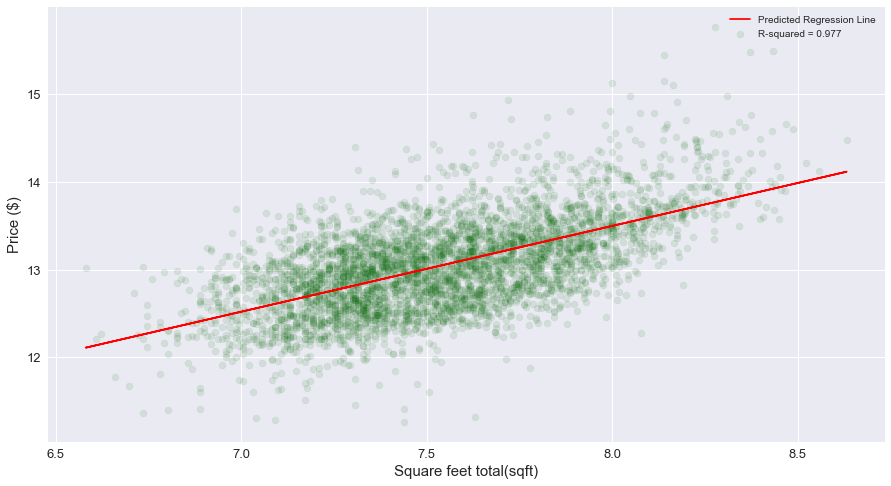

In [53]:
#plotting a regression line to visualize how well the square feet basement correlates
#with price
plt.figure(figsize=(15,8))
plt.scatter(X_test,y_test,color='darkgreen',label="R-squared = 0.977", alpha=.1)
plt.plot(X_test,lr.predict(X_test),color="red",label="Predicted Regression Line")
plt.xlabel("Square feet total(sqft)", fontsize=15)
plt.ylabel("Price ($)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig("images/sqfttotal.png", bbox_inches='tight')

From the graphs, we infer that increase in square feet increases the price of the house more than increase in basement space. It would seem the demographic favors more space, maybe due to the scarcity of space in the county. More analysis is needed to understand this.
We can confirm this in our regression plots of the various features.

## Evaluation

As a whole, approximately 85% of the variations in dependent variable, price, are explained by the independent variables in our model. The model takes into account features such as square feet of the living space, number of bedrooms, bathrooms and so on to try and approximate the best combination of features that will accurately predict the price of a house. We started the model off by taking in the raw features and seeing how well it would predict future prices. We achieved an R-squared value of 0.75, however, we did not satisfy the requirement that our residuals must be normally distributed. This was shown when we plotted our residuals and saw that our data has skew and it was heteroskedastic. We then proceeded to improve our model by noamlizing our underlying data and scaling it to reduce the effect that some of the features have on the effectiveness of our model. Doing this, we were able to achieve an R-squared value of 0.85, expalaining 85% of the variations in the price of our houses. Additionally, we can look at the effect of individual features in our model. Features like square feet seem to have more effect on the price than other features. More analysis is needed.


## Conclusion

King County Real Estate Services should focus on: 

1. Building houses with more square feet above the ground and more square feet in general.
2. Building houses with 1-3 bathrooms for more economy.
3. Building houses with a higher grade.
4. Renovating existing houses to achieve higher grade.